# Notebook 3: Model Setup and Evaluation

## Introduction

## Methodology

## Model Preprocessing

### Import Libraries
We begin by importing all the libraries required to run this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer



# Define some default visualizaiton display properties

# Ensure plots are always centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


### Read in Dataset

We now read in the review dataset that was cleaned in Notebook 2.

In [2]:
df = pd.read_csv('../data/review_data_cleaned.csv')
df.head()

,date,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Specialty Food,stars,useful,funny,cool,text,fans,checkins_per_week,reviews_per_week,tips_per_week
0,2016-03-07 17:58:53,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,4,0,0,0,Pizza here is delicious. I tried it once a few...,0,0.076064,0.058773,0.041854
1,2014-05-10 11:35:46,42.475805,-70.926544,201,1,1,0,0,1,2,...,0,5,0,0,0,Delicious! My co-workers came back from lunch...,0,0.271863,0.355628,0.075452
2,2014-07-18 14:36:15,42.520691,-70.894220,141,1,1,0,1,1,1,...,0,5,0,0,1,I really miss this place. I used to work in S...,0,0.728551,0.194107,0.053206
3,2010-01-10 17:33:51,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,4,1,0,0,love this place! really good pizza and probabl...,0,0.076064,0.058773,0.041854
4,2012-02-13 05:53:37,42.540409,-71.153318,66,1,1,1,1,1,1,...,0,2,5,1,0,"Saw that they won a ""Sandie"" award from Phanto...",0,0.054909,0.110338,0.017194


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 47 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   date                        1364840 non-null  object 
 1   latitude                    1364840 non-null  float64
 2   longitude                   1364840 non-null  float64
 3   review_count                1364840 non-null  int64  
 4   is_open                     1364840 non-null  int64  
 5   RestaurantsGoodForGroups    1364840 non-null  int64  
 6   HasTV                       1364840 non-null  int64  
 7   GoodForKids                 1364840 non-null  int64  
 8   RestaurantsTakeOut          1364840 non-null  int64  
 9   RestaurantsPriceRange2      1364840 non-null  int64  
 10  RestaurantsReservations     1364840 non-null  int64  
 11  RestaurantsAttire           1364840 non-null  object 
 12  RestaurantsDelivery         1364840 non-null  int64  
 1

### Converting Date Column

We can see that the `date` column is of an object data type. It would be more convenient, if we could extract the individual components of the date as separate numeric columns (e.g. year, month, etc., of the review). To do this, we first convert the `date` column to a `datetime` format and then extract the components of interest. 

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.insert(loc=0, column='Year', value=df['date'].dt.year)
df.insert(loc=1, column='Month', value=df['date'].dt.month)
df.insert(loc=2, column='Day', value=df['date'].dt.day)
df.insert(loc=3, column='Day of Week', value=df['date'].dt.weekday)
df.insert(loc=4, column='Hour', value=df['date'].dt.hour)
df.insert(loc=5, column='Minute', value=df['date'].dt.minute)
df.drop('date', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 52 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

We have successfully converted the date components to separate integer columns.

### Ordering the columns

In [6]:
# Get  columns whose data type is object
object_columns = df.dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi', 'text']

In [7]:
temp_df = df[object_columns]
temp_df

,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,casual,average,none,no,I really miss this place. I used to work in S...
3,casual,average,none,free,love this place! really good pizza and probabl...
4,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."
...,...,...,...,...,...
1364835,casual,average,beer_and_wine,no,We need restaurants like this to remind us whe...
1364836,casual,average,beer_and_wine,no,Food is good but small portions ! A bit overly...
1364837,casual,average,beer_and_wine,no,I had orders the pasta carbonara for a pick up...
1364838,casual,average,full_bar,no,"As I said, my family and I gave the Jury Room ..."


In [8]:
df = pd.concat([df.drop(columns = object_columns), temp_df], axis=1)
df.head()


,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,fans,checkins_per_week,reviews_per_week,tips_per_week,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,0,0.076064,0.058773,0.041854,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,0,0.271863,0.355628,0.075452,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,1,0,0.728551,0.194107,0.053206,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,0,0.076064,0.058773,0.041854,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,0,0,0.054909,0.110338,0.017194,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


### Define X and y

In [9]:
X = df.drop(['stars'], axis=1)
X.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,fans,checkins_per_week,reviews_per_week,tips_per_week,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,0,0.076064,0.058773,0.041854,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,0,0.271863,0.355628,0.075452,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,1,0,0.728551,0.194107,0.053206,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,0,0.076064,0.058773,0.041854,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,0,0,0.054909,0.110338,0.017194,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


In [10]:
y = df['stars']
y.head()

0    4
1    5
2    5
3    4
4    2
Name: stars, dtype: int64

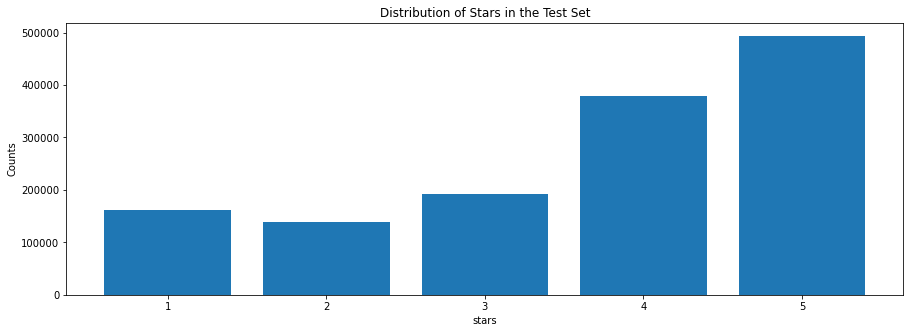

In [11]:
plt.figure(figsize=(15,5))
plt.bar(y.value_counts().sort_index().index.astype('str'),
        y.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')
plt.show()

In [12]:
X_sampled, y_sampled = resample(X, y, random_state=0, 
                                    n_samples = 0.01*X.shape[0],
                                    replace=False, stratify=y)

In [13]:
print(f'X_sampled_shape: {X_sampled.shape}')
print(f'y_sampled_shape: {y_sampled.shape}')

X_sampled_shape: (13648, 51)
y_sampled_shape: (13648,)


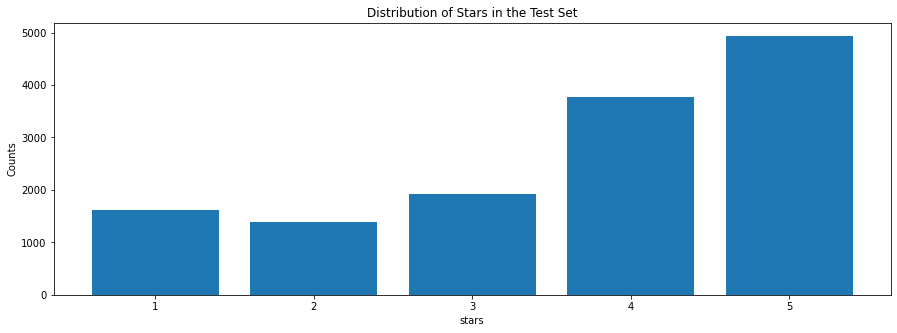

In [14]:
plt.figure(figsize=(15,5))
plt.bar(y_sampled.value_counts().sort_index().index.astype('str'),
        y_sampled.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')
plt.show()

### Check Correlation with Number of stars

In [15]:
def correlation_coeff(X, y):
    
    correlation_df = pd.DataFrame(columns=['Variable', 'Correlation Coefficient', 'p-value'])
    
    for column in X.columns:
        corr_coef, p_value = stats.pearsonr(X[column], y)
        correlation_df = correlation_df.append({'Variable': column,
                                                'Correlation Coefficient': corr_coef,
                                                'p-value': p_value}, ignore_index=True)
        correlation_df.sort_values(by='Correlation Coefficient', ascending=False, inplace=True)
    
    return correlation_df


In [16]:
#correlation_coeff(X,y)

### Check for Multicollinearity

In [17]:
'''def high_correlation(x, color):
    threshold = 0.5
    return f'color: {color};' if x < -1*(threshold) or x > threshold else None

X.corr().style.applymap(high_correlation, color='red')'''

"def high_correlation(x, color):\n    threshold = 0.5\n    return f'color: {color};' if x < -1*(threshold) or x > threshold else None\n\nX.corr().style.applymap(high_correlation, color='red')"

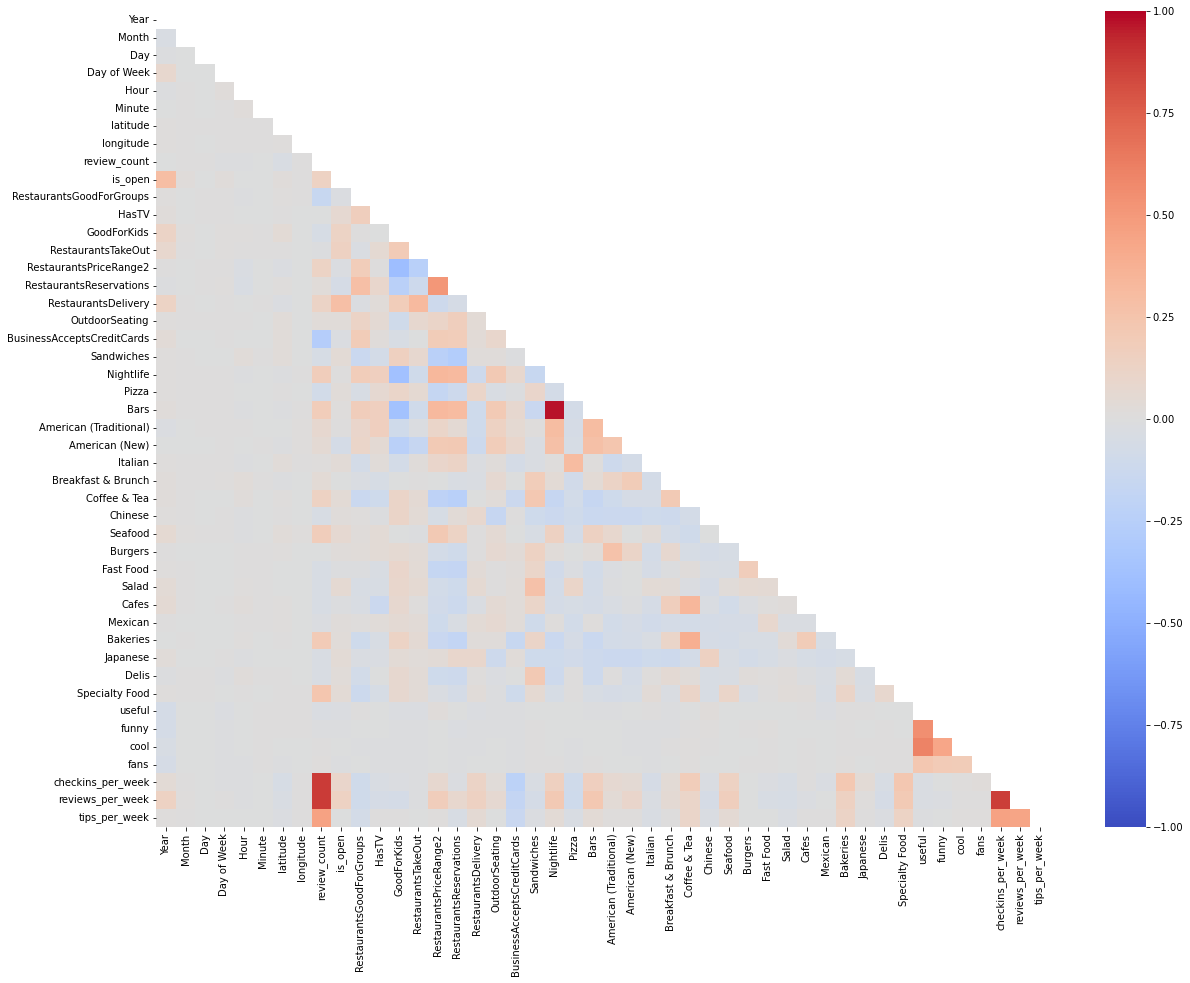

In [18]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(X.corr()))

sns.heatmap(X.corr(), cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.show()

## Modelling

### Defining Train and Test Sets

In [19]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size = 0.2, stratify=y_sampled, random_state=0)

print(f'Shape of X_train: {X_train.shape}. Shaper of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shaper of y_test: {y_test.shape}')

Shape of X_train: (10918, 51). Shaper of y_train: (10918,)
Shape of X_test: (2730, 51). Shaper of y_test: (2730,)


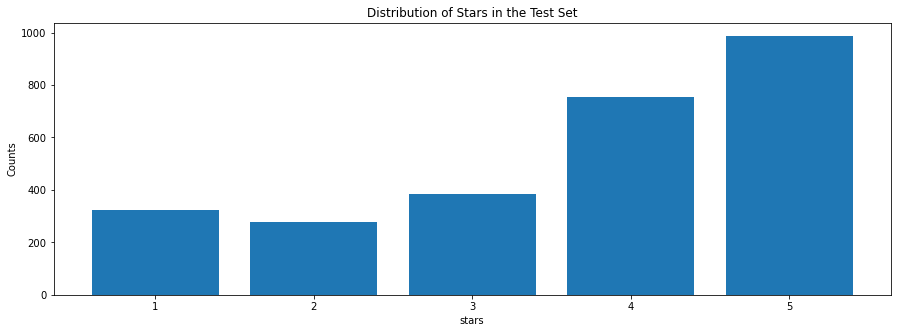

In [20]:
plt.figure(figsize=(15,5))
plt.bar(y_test.value_counts().sort_index().index.astype('str'),
        y_test.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')
plt.show()

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10918 entries, 118838 to 910818
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        10918 non-null  int64  
 1   Month                       10918 non-null  int64  
 2   Day                         10918 non-null  int64  
 3   Day of Week                 10918 non-null  int64  
 4   Hour                        10918 non-null  int64  
 5   Minute                      10918 non-null  int64  
 6   latitude                    10918 non-null  float64
 7   longitude                   10918 non-null  float64
 8   review_count                10918 non-null  int64  
 9   is_open                     10918 non-null  int64  
 10  RestaurantsGoodForGroups    10918 non-null  int64  
 11  HasTV                       10918 non-null  int64  
 12  GoodForKids                 10918 non-null  int64  
 13  RestaurantsTakeOut       

### Column Transformer

In [22]:
numeric_columns = X_train.dtypes[df.dtypes != 'object'].index.to_list()
numeric_columns

['Year',
 'Month',
 'Day',
 'Day of Week',
 'Hour',
 'Minute',
 'latitude',
 'longitude',
 'review_count',
 'is_open',
 'RestaurantsGoodForGroups',
 'HasTV',
 'GoodForKids',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'BusinessAcceptsCreditCards',
 'Sandwiches',
 'Nightlife',
 'Pizza',
 'Bars',
 'American (Traditional)',
 'American (New)',
 'Italian',
 'Breakfast & Brunch',
 'Coffee & Tea',
 'Chinese',
 'Seafood',
 'Burgers',
 'Fast Food',
 'Salad',
 'Cafes',
 'Mexican',
 'Bakeries',
 'Japanese',
 'Delis',
 'Specialty Food',
 'useful',
 'funny',
 'cool',
 'fans',
 'checkins_per_week',
 'reviews_per_week',
 'tips_per_week']

In [23]:
categorical_columns = X_train.drop('text', axis=1).dtypes[df.dtypes == 'object'].index.to_list()
categorical_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi']

In [24]:
%%time

# full_pipeline = ColumnTransformer([
#     ('num', MinMaxScaler(), numeric_columns),
#     ('cat', OneHotEncoder(drop='first'), categorical_columns),
#     ('review', ReviewTextTransformer(), 'text')
# ])

full_pipeline = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', CountVectorizer(stop_words= 'english', min_df=10), 'text')
])

full_pipeline.fit(X_train)
temp_df = full_pipeline.transform(X_train).todense()

CPU times: user 1.53 s, sys: 105 ms, total: 1.63 s
Wall time: 1.45 s


In [25]:
temp_df.shape

(10918, 4666)

In [26]:
encoded_columns1 = full_pipeline.transformers_[1][1].get_feature_names_out()
encoded_columns1

array(['RestaurantsAttire_dressy', 'NoiseLevel_loud', 'NoiseLevel_quiet',
       'NoiseLevel_very_loud', 'Alcohol_full_bar', 'Alcohol_none',
       'WiFi_no', 'WiFi_paid'], dtype=object)

In [27]:
encoded_columns2 = full_pipeline.transformers_[2][1].get_feature_names_out()
encoded_columns2
# clf.named_steps['preprocessor'].transformers_[1][1]\
#    .named_steps['onehot'].get_feature_names(categorical_features)

array(['00', '00pm', '10', ..., 'zero', 'ziti', 'zucchini'], dtype=object)

In [28]:
print(type(numeric_columns))
len(numeric_columns)

<class 'list'>


46

In [29]:
columns = np.concatenate([numeric_columns, encoded_columns1, encoded_columns2])
columns.shape

(4666,)

In [30]:
X_train_scaled = pd.DataFrame(columns=columns,data=temp_df)
print(X_train_scaled.shape)
X_train_scaled.head()

(10918, 4666)


,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,younger,yr,yuck,yum,yummy,yup,zen,zero,ziti,zucchini
0,0.3125,0.909091,0.200000,1.0,0.521739,0.728814,0.586507,0.001951,0.047306,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8125,0.818182,0.100000,0.5,0.608696,0.135593,0.503246,0.002397,0.008501,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9375,0.636364,0.266667,1.0,0.043478,0.322034,0.478006,0.002232,0.058001,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1875,0.545455,0.533333,0.5,0.000000,0.288136,0.524001,0.002089,0.033731,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8750,0.000000,1.000000,0.5,0.869565,0.847458,0.439284,0.001572,0.043878,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X_train.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,fans,checkins_per_week,reviews_per_week,tips_per_week,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
118838,2010,11,7,6,12,43,42.395293,-71.121620,350,1,...,0,20,0.568873,0.454122,0.043941,casual,average,beer_and_wine,no,I've been waiting for the longest time to chec...
984277,2018,10,4,3,14,8,42.353567,-71.058031,67,1,...,0,0,0.724138,0.512568,1.000000,casual,average,beer_and_wine,free,Great service and a very nice vibe to the plac...
778602,2020,8,9,6,1,19,42.340918,-71.081615,428,1,...,0,0,1.698991,1.745120,0.088950,dressy,average,full_bar,no,"Wow, what a treat! Friends raved about this re..."
483464,2008,7,17,3,0,17,42.363968,-71.101869,251,0,...,0,7,0.814356,0.581037,0.084580,casual,average,full_bar,no,"You know, for how pricey the food is, I'm surp..."
496132,2019,1,31,3,20,50,42.321512,-71.175672,325,1,...,0,0,0.858462,1.037719,0.071828,casual,average,full_bar,free,It's my favorite place for a special dinner I ...


In [32]:
temp_df = full_pipeline.transform(X_test).todense()
temp_df.shape

(2730, 4666)

In [33]:
X_test_scaled = pd.DataFrame(columns=columns,data=temp_df)
print(X_test_scaled.shape)
X_test_scaled.head()

(2730, 4666)


,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,younger,yr,yuck,yum,yummy,yup,zen,zero,ziti,zucchini
0,0.8750,0.272727,0.666667,1.000000,0.956522,0.593220,0.475821,0.002164,0.018237,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.9375,0.000000,0.366667,1.000000,0.086957,0.525424,0.693166,0.001199,0.053476,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4375,0.545455,0.233333,1.000000,0.086957,0.949153,0.570383,0.001972,0.086384,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6250,1.000000,0.466667,0.166667,0.043478,0.474576,0.514237,0.002389,0.091320,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.3750,0.636364,0.833333,0.666667,0.826087,0.067797,0.555869,0.002142,0.013300,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_test_scaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,younger,yr,yuck,yum,yummy,yup,zen,zero,ziti,zucchini
0,0.8750,0.272727,0.666667,1.000000,0.956522,0.593220,0.475821,0.002164,0.018237,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.9375,0.000000,0.366667,1.000000,0.086957,0.525424,0.693166,0.001199,0.053476,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4375,0.545455,0.233333,1.000000,0.086957,0.949153,0.570383,0.001972,0.086384,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6250,1.000000,0.466667,0.166667,0.043478,0.474576,0.514237,0.002389,0.091320,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.3750,0.636364,0.833333,0.666667,0.826087,0.067797,0.555869,0.002142,0.013300,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Defining Custom Scoring Functions

In [35]:
def bound_predict(y_pred):
    y_pred = np.where(y_pred > 5, 5, y_pred)
    y_pred = np.where(y_pred < 1, 1, y_pred)
    return y_pred

In [36]:
def custom_mae_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return mean_absolute_error(y_true, y_pred)

def custom_r2_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return r2_score(y_true, y_pred)

custom_mae_scorer = make_scorer(custom_mae_scorer_func, greater_is_better=False)
custom_r2_scorer = make_scorer(custom_r2_scorer_func, greater_is_better=True)

scorer = {'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
          'custom_r2_scorer': make_scorer(custom_r2_scorer_func, greater_is_better=True)}

### Dummy Model

In [37]:
from sklearn.dummy import DummyRegressor

In [38]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_test_scaled, y_test)

DummyRegressor()

In [39]:
prediction = dummy_reg.predict(X_test_scaled)
mean_absolute_error(y_test, prediction)

1.1557340095801636

In [40]:
custom_mae_scorer_func(y_test, prediction)

1.1557340095801636

### Linear Regression

#### Default Parameters

In [41]:
%%time
# Define the model
lin_reg = LinearRegression()

# Cross validation score
# scores = cross_validate(lin_reg, X_train_scaled, y_train, cv=5,
#                                scoring=('custom_mae_scorer', 'custom_r2_scorer', 'r2'))

scores = cross_validate(lin_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

CPU times: user 43min 23s, sys: 42.1 s, total: 44min 5s
Wall time: 4min 9s


In [44]:
scores

{'fit_time': array([48.43591213, 48.08455586, 48.04043388, 55.51713204, 48.71887112]),
 'score_time': array([0.04415917, 0.03876305, 0.04004908, 0.04107499, 0.03967881]),
 'test_custom_mae_scorer': array([-0.91131665, -0.937041  , -0.87061525, -0.90402939, -0.87482765]),
 'test_custom_r2_scorer': array([0.19472525, 0.15854103, 0.27276235, 0.18042196, 0.23362688])}

In [46]:
print('MAE Score:')
print(-scores['test_custom_mae_scorer'])
print(np.mean(-scores['test_custom_mae_scorer']))
print('\n')

print('R^2 Score:')
print(scores['test_custom_r2_scorer'])
print(np.mean(scores['test_custom_r2_scorer']))

MAE Score:
[0.91131665 0.937041   0.87061525 0.90402939 0.87482765]
0.8995659895135647


R^2 Score:
[0.19472525 0.15854103 0.27276235 0.18042196 0.23362688]
0.20801549155298033


In [ ]:
# # Evaluate the model
# lin_reg.fit(X_train, y_train)

# prediction = lin_reg.predict(X_test)

# print(f'The R^2 score is: {r2_score(y_test, prediction)}')
# print(f'The MAE is: {mean_absolute_error(y_test, prediction)}')

In [ ]:
# fitted_values = lin_reg.predict(X_train)
# residuals = (y_train - fitted_values)

# plt.figure(figsize=(15,10))
# plt.scatter(fitted_values, residuals)
# plt.xlabel('Fitted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot', fontsize=20)
# plt.show()

#### Adding L2 Regularization

In [ ]:
# # Define the model
# ridge_reg = Ridge(alpha=1.0)

# # Cross validation score
# scores = cross_validate(ridge_reg, X_train_scaled, y_train, cv=5,
#                                scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'))

# print('MAE Score:')
# print(-scores['test_neg_mean_absolute_error'])
# print(np.mean(-scores['test_neg_mean_absolute_error']))
# print('\n')


# print('R^2 Score:')
# print(scores['test_r2'])
# print(np.mean(scores['test_r2']))

In [47]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for power in range(-0, 8, 1):
    alpha = 10**power
    ridge_reg = Ridge(alpha=alpha)

    
    cv_scores = cross_validate(ridge_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores
    

CPU times: user 15min 42s, sys: 1min 2s, total: 16min 44s
Wall time: 1min 58s


,alpha,MAE,R-squared
0,1.0,0.822047,0.353399
1,10.0,0.733116,0.511540
2,100.0,0.728004,0.541471
3,1000.0,0.820975,0.446802
4,10000.0,1.003197,0.213991
5,100000.0,1.130105,0.039722
6,1000000.0,1.152660,0.004251
7,10000000.0,1.155121,0.000229


In [48]:
def regression_plots(scores, model_description):
    plt.subplots(1,2, figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(scores['alpha'], scores['MAE'], label='Mean Absolute Error', color='orange')
    plt.xscale('log')
    plt.legend()
    plt.title('MAE Variation with ' + model_description)
    plt.xlabel('Alpha')


#     plt.subplot(1,3,2)
#     plt.plot(scores['alpha'], scores['RMSE'], label='Root Mean Squared Error', color='blue')
#     plt.xscale('log')
#     plt.legend()
#     plt.title('RMSE variation with ' + model_description)
#     plt.xlabel('Alpha')

    plt.subplot(1,2,2)
    plt.plot(scores['alpha'], scores['R-squared'], label='R^2', color='green')
    plt.xscale('log')
    plt.legend()
    plt.title('R^2 variation with ' + model_description)
    plt.xlabel('Alpha')

    plt.tight_layout()
    plt.show()
    

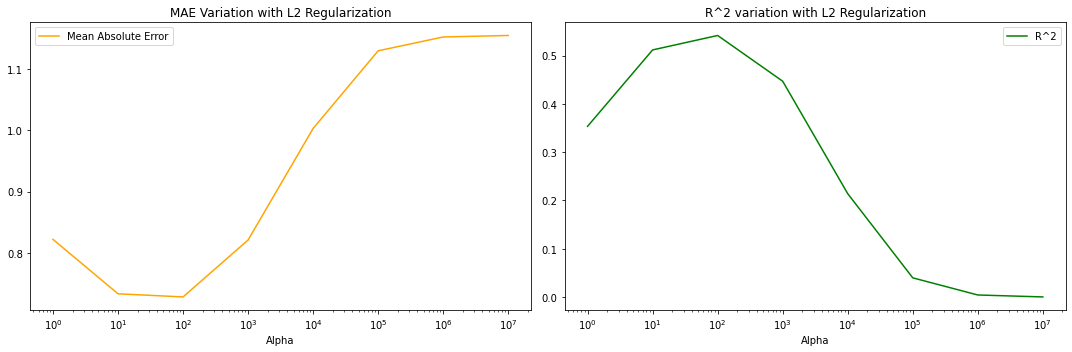

In [49]:
regression_plots(scores, 'L2 Regularization')

In [50]:
def plot_fitted_values(fitted_values, y, model_description):
    plt.figure(figsize=(10,5))
    plt.scatter(fitted_values, y, alpha=0.1)
    plt.title('Fitted versus Actual Values for ' + model_description)
    plt.xlabel('Fitted Values')
    plt.ylabel('Actual Values')

plt.show()
    

In [54]:
ridge_reg = Ridge(alpha=100)
ridge_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled))
print(custom_mae_scorer_func(y_train, fitted_values))
print(custom_r2_scorer_func(y_train, fitted_values))

0.6353623887101916
0.646161548485509


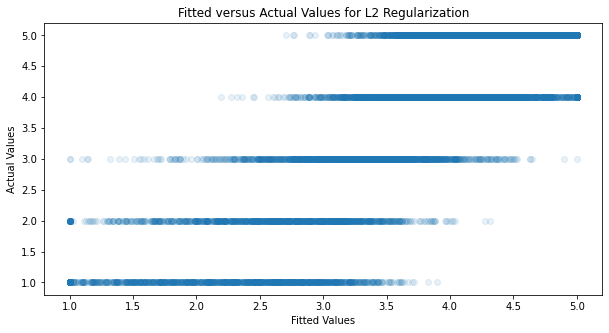

In [55]:
plot_fitted_values(fitted_values, y_train, 'L2 Regularization')

0.7278958804135554
0.5391092927843312


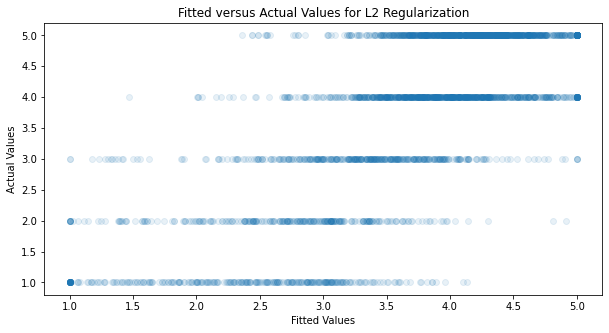

In [56]:
fitted_values = bound_predict(ridge_reg.predict(X_test_scaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'L2 Regularization')

In [ ]:
# residuals = ridge_reg.predict(X_train_scaled) - y_train

In [56]:
# def plot_residuals(X_train, residuals):
#     num_rows = int(np.ceil(X_train.shape[1]/4))
#     plt.subplots(num_rows, 4, figsize=(15,20))
    
#     for i in range(0, X_train.shape[1]):
#         plt.subplot(num_rows, 4, i+1)
#         plt.scatter(X_train.iloc[:,i], residuals, alpha=0.1)
#         plt.xlabel(X_train.columns[i])
        
    
#     plt.tight_layout()
#     plt.show()
                 
                 

In [57]:
#plot_residuals(X_train, residuals)

#### Adding L1 Regularization

In [57]:
# # Define the model
# lasso_reg = Lasso(alpha=1.0)

# # Cross validation score
# scores = cross_validate(lasso_reg, X_train_scaled, y_train, cv=5,
#                                scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'))

# print('MAE Score:')
# print(-scores['test_neg_mean_absolute_error'])
# print(np.mean(-scores['test_neg_mean_absolute_error']))
# print('\n')


# print('R^2 Score:')
# print(scores['test_r2'])
# print(np.mean(scores['test_r2']))

In [59]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for power in range(-4, 4, 1):
    alpha = 10**power
    lasso_reg = Lasso(alpha=alpha)

    
    cv_scores = cross_validate(lasso_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

CPU times: user 15min 48s, sys: 24.3 s, total: 16min 12s
Wall time: 2min 35s


,alpha,MAE,R-squared
0,0.0001,0.772417,0.439508
1,0.0010,0.723994,0.541563
2,0.0100,0.824367,0.436907
3,0.1000,1.099397,0.078374
4,1.0000,1.155397,-0.000224
5,10.0000,1.155397,-0.000224
6,100.0000,1.155397,-0.000224
7,1000.0000,1.155397,-0.000224


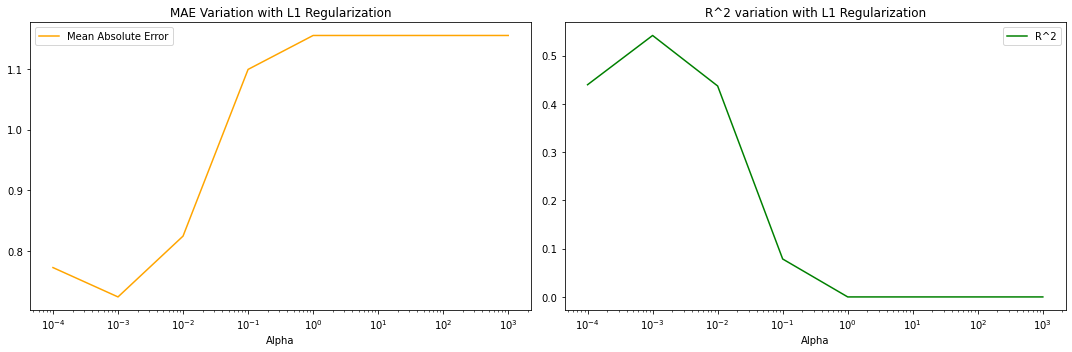

In [60]:
regression_plots(scores, 'L1 Regularization')

0.667160263585825
0.6111383359054209


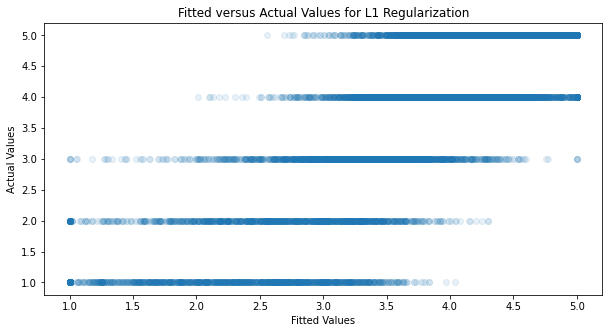

In [64]:
final_lasso_reg = Lasso(alpha=10**(-3))
final_lasso_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(final_lasso_reg.predict(X_train_scaled))
print(mean_absolute_error(y_train, fitted_values))
print(r2_score(y_train, fitted_values))
plot_fitted_values(fitted_values, y_train, 'L1 Regularization')

0.7261862877372134
0.5372981016696965


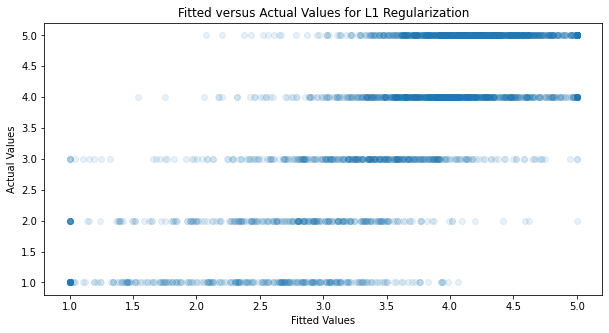

In [65]:
fitted_values = bound_predict(final_lasso_reg.predict(X_test_scaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'L1 Regularization')

### Decision Tree

In [67]:
DT_model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=10, random_state=0)
DT_model.fit(X_train_scaled, y_train)

print(mean_absolute_error(y_train, DT_model.predict(X_train_scaled)))
print(r2_score(y_train, DT_model.predict(X_train_scaled)))

0.6308462879217522
0.5986353600699075


0.8719392786106255
0.2689292754202337


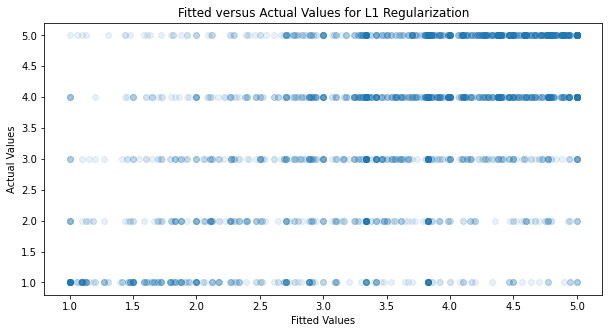

In [68]:
fitted_values = DT_model.predict(X_test_scaled)
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'L1 Regularization')

In [64]:
DT_model.get_depth()

78

In [63]:
# residuals = DT_model.predict(X_train) - y_train

# plot_residuals(X_train, residuals)

In [69]:
%%time

DT_model = DecisionTreeRegressor(min_samples_leaf=2, random_state=0)

# Cross validation score
scores = cross_validate(DT_model, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

print('MAE Score:')
print(-scores['test_custom_mae_scorer'])
print(np.mean(-scores['test_custom_mae_scorer']))
print('\n')


print('R^2 Score:')
print(scores['test_custom_r2_scorer'])
print(np.mean(scores['test_custom_r2_scorer']))


MAE Score:
[0.89934371 0.94398657 0.96039377 0.89143381 0.94655673]
0.9283429173259682


R^2 Score:
[ 0.05919403 -0.00530444 -0.01732993  0.09164852 -0.00296373]
0.025048890064847295


In [73]:
%%time

DT_reg = DecisionTreeRegressor()

param_grid = [{'max_depth': [25, 50, 70], 'min_samples_leaf': [2, 4, 6]}]

grid_search = GridSearchCV(DT_reg, param_grid, cv=5, scoring=scorer, refit='custom_mae_scorer')

grid_search.fit(X_train_scaled, y_train)

CPU times: user 8min 49s, sys: 8.61 s, total: 8min 57s
Wall time: 8min 59s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [25, 50, 70],
                          'min_samples_leaf': [2, 4, 6]}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)})

In [74]:
grid_search.best_params_

{'max_depth': 25, 'min_samples_leaf': 6}

In [75]:
best_DT_reg = grid_search.best_estimator_
best_DT_reg

DecisionTreeRegressor(max_depth=25, min_samples_leaf=6)

0.5534225392864824
0.6680304266679891


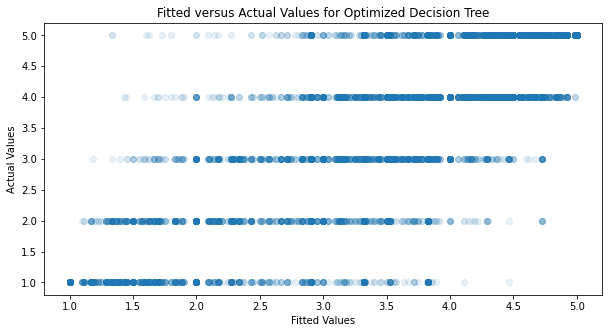

In [77]:
best_DT_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(best_DT_reg.predict(X_train_scaled))
print(mean_absolute_error(y_train, fitted_values))
print(r2_score(y_train, fitted_values))
plot_fitted_values(fitted_values, y_train, 'Optimized Decision Tree')

0.8702423732322755
0.2542343623505233


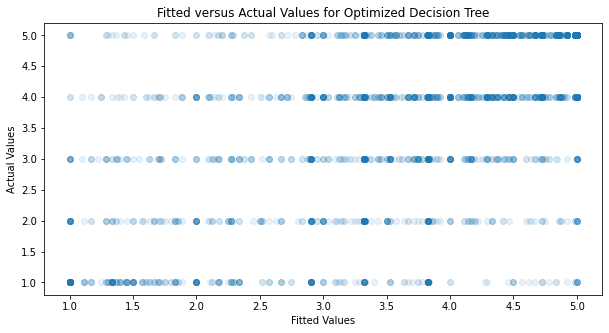

In [78]:
fitted_values = bound_predict(best_DT_reg.predict(X_test_scaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'Optimized Decision Tree')

### Random Forest

In [ ]:
forest_reg = RandomForestRegressor(min_samples_leaf=2)
forest_reg.fit(X_train_scaled, y_train)

In [69]:
r2_score(y_train, forest_reg.predict(X_train_scaled))

0.9041532967475253

In [70]:
mean_absolute_error(y_train, forest_reg.predict(X_train_scaled))

0.3176624379111556

In [86]:
forest_reg = RandomForestRegressor(min_samples_leaf=2, random_state=0)

# Cross validation score
scores = cross_validate(forest_reg, X_train_scaled, y_train, cv=5,
                               scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'))

print('MAE Score:')
print(-scores['test_neg_mean_absolute_error'])
print(np.mean(-scores['test_neg_mean_absolute_error']))
print('\n')


print('R^2 Score:')
print(scores['test_r2'])
print(np.mean(scores['test_r2']))

MAE Score:
[0.46910552 0.4725692  0.46414884 0.48611675 0.47712378]
0.47381281973864986


R^2 Score:
[0.32382648 0.27829754 0.30351497 0.29672769 0.24482766]
0.2894388682883857


In [87]:
forest_reg.fit(X_train, y_train)
print(r2_score(y_test, forest_reg.predict(X_test)))
print(mean_absolute_error(y_test, forest_reg.predict(X_test)))

0.2635186390310038
0.4802346758047759


In [66]:
# residuals = forest_reg.predict(X_train) - y_train

# plot_residuals(X_train, residuals)

In [72]:
%%time

forest_reg = RandomForestRegressor()

param_grid = [{'n_estimators': [50], 'max_depth': [25, 50, 70], 'min_samples_leaf': [2, 4, 6]}]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring=scorer, refit='custom_mae_scorer')

grid_search.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [50]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=8, min_samples_leaf=2, n_estimators=30)

In [51]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 30}

In [52]:
grid_search.best_score_

-0.8995640789678149

In [ ]:
best_forest_reg = grid_search.best_estimator_

best_forest_reg.fit(X_train_scaled, y_train)